# Wavelet Generative Adversarial Networks
## Initialisation and dataset preparation

First, let us import the required libraries.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pywt
from misceallaneous import getWavFileAsNpArray, displaySpectrogram
from IPython.display import Audio
import librosa
import librosa.display

Then, let us include the dataset.

The dataset is made of two files: `clean/p1.wav`and `white/p1.wav` which are converted into arrays of `int32` and then split into segments of `samples_length`.

The goal of the CGAN here is to predict the clean sample, when fed with the white one.

In [3]:
wavelet_family = "db38"

In [4]:
samplerate = 12000
nperseg = 1024

clean = getWavFileAsNpArray("../dataset_2/clean/p1.wav")
white = getWavFileAsNpArray("../dataset_2/white/p1.wav")
clean = np.array(clean, dtype="float32")
white = np.array(white, dtype="float32")

clean_dataset = []
white_dataset = []

samples_length = nperseg*2

for i in range(0, clean.shape[0]-samples_length, samples_length):
    clean_dataset.append(clean[i:i+samples_length])
    white_dataset.append(white[i:i+samples_length])
clean_dataset = np.array(clean_dataset)
white_dataset = np.array(white_dataset)


ex = clean_dataset[0]
ca, cd = pywt.dwt(ex, wavelet_family, "per")
data_shape = ca.shape

In [5]:
wavelet_clean_dataset = []
wavelet_white_dataset = []

for sample in clean_dataset:
    ca, cd = pywt.dwt(sample, wavelet_family, "per")
    wavelet_clean_dataset.append(np.concatenate((ca, cd)))
for sample in white_dataset:
    ca, cd = pywt.dwt(sample, wavelet_family, "per")
    wavelet_white_dataset.append(np.concatenate((ca, cd)))
    
max_clean = np.max(np.abs(wavelet_clean_dataset))
wavelet_clean_dataset = np.array(wavelet_clean_dataset)/(max_clean)

max_white = np.max(np.abs(wavelet_white_dataset))
wavelet_white_dataset = np.array(wavelet_white_dataset)/(max_white)

print(np.max(wavelet_white_dataset))
print(wavelet_white_dataset.shape)

0.790526
(5329, 2048)


In [6]:
def display_audio(data, g=None, p=0, i=0):
    audio = hear_audio(data, g, p, i)
    D = librosa.stft(audio)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(S_db, x_axis='time', y_axis='mel', sr=samplerate)
    #plt.show()
    plt.savefig(str(p)+".png", format='png')
    
def hear_audio(data, g=None, p=0, i=0):
    if g == None:
        ca = data[i, :data_shape[0]]*max_clean
        cd = data[i, data_shape[0]:]*max_clean
    else:
        cacd = g.predict(np.reshape(data[i], (-1, data_shape[0]*2)))[0]
        ca = cacd[:data_shape[0]]*max_clean
        cd = cacd[data_shape[0]:]*max_clean
    audio = pywt.idwt(ca, cd, wavelet_family, "per")
    return audio

def get_distance_audio(white, clean, g, n):
    res = 0
    for i in range(n):
        d = np.reshape(white[i], (-1, data_shape[0]*2))
        data = (g.predict(d))[0]
        res += np.sum((data-clean[i])**2)
    return res/n

# GAN Model
The main idea of a GAN model is to create two networks who play an adversarial game:
- A Generator, whose goal is to produce the most realistic samples possible to fool the Discriminator
- A Discriminator, whose goal is to correctly guess if its input is a real sample from the clean dataset or an output created by the Generator

In [17]:
def discriminator(sizes, lr=0.0001):
    inputs = tf.keras.Input(shape=(sizes[1]))
    x = tf.keras.layers.Dropout(0.3)(inputs)
    x1 = tf.keras.layers.Dense(512, activation="tanh")(x)
    x2 = tf.keras.layers.Dense(64, activation="tanh")(x1)
    outputs = tf.keras.layers.Dense(1, activation="tanh")(x2)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="discriminator")
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=['accuracy'])
    return model

## Generator
The generator itself is a Convolutionnal Autoencoder.

Its input size and output size are both the size of the stft array.

In [18]:
def generator(sizes, lr=0.0001):
    inputs = tf.keras.Input(shape=(sizes[1]))
    x = tf.keras.layers.Dropout(0.2)(inputs)
    x1 = tf.keras.layers.Dense(512, activation="tanh")(x)
    x2 = tf.keras.layers.Dense(128, activation="relu")(x1)
    x3 = tf.keras.layers.Dense(512, activation="tanh")(x2)
    #a = tf.keras.layers.Add()([x1, x3])
    outputs = tf.keras.layers.Dense(sizes[1], activation="tanh")(x3)
    #outputs = tf.keras.layers.Add()([inputs, x4])
    #outputs = tf.keras.layers.Dense(sizes[1], activation="tanh")(x1)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="autoencoder")
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=['accuracy'])
    return model

## Building the GAN

In [27]:
def get_generator_outputs(white, train_size, g, nperseg, clean):
    steps = train_size//20
    rng = np.random.default_rng()
    g_outputs = []
    batch = rng.choice(white, train_size)
    for i in range(train_size):
        if i%steps == 0:
            print("=", end='')
        t = np.reshape(white[i, :], (-1, white.shape[1]))
        m = g.predict(t)
        g_outputs.append(m)
    print()
    g_outputs = np.reshape(np.array(g_outputs), (train_size,  white.shape[1]))
    input_data = np.concatenate((g_outputs, clean[:train_size,]))
    output_data = np.concatenate((np.zeros((train_size,)), np.ones((train_size,))))
    return input_data, output_data

In [28]:
class GAN:
    def __init__(self, size, g, d):
        self.g = g
        self.d = d
        self.size = size
        self.build()
        
    def build(self):
        self.z = self.g.inputs
        self.image = self.g(self.z)
        self.valid = self.d(self.image)
        self.combined_network = tf.keras.Model(self.z, self.valid)
        self.compile()
        
    def block_discriminator(self):
        self.d.trainable = False
        self.g.trainable = True
        self.build()
        
    def block_generator(self):
        self.g.trainable = False
        self.d.trainable = True
        self.build()
        
    def compile(self):
        self.combined_network.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [29]:
def train_on_batch(d, i, o, validation_split=0, batch_size=16, verbose=True):
    history = d.fit(i, o, batch_size=batch_size, validation_split=validation_split, verbose=verbose)
    return np.mean(history.history['accuracy'])

In [48]:
discriminator_train_size = wavelet_white_dataset.shape[0]
generator_train_size = wavelet_white_dataset.shape[0]

In [49]:
d = discriminator(wavelet_white_dataset.shape)
g = generator(wavelet_white_dataset.shape)
gan = GAN(wavelet_white_dataset.shape, g, d)

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 2048)]            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_36 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 65        
Total params: 1,081,985
Trainable params: 1,081,985
Non-trainable params: 0
_________________________________________________________________
Model: "autoencoder"
_________________________________________________________________
Layer (type)          

### Training the GAN

In [50]:
p = 1
q = 1
e = 0

Step 0
Training the discriminator
Generator error is 28.18254663810134
667/667 [==============================] - 2s 4ms/step - loss: 0.0340 - accuracy: 0.9619
Training the generator
1333/1333 [==============================] - 13s 10ms/step - loss: 0.0054 - accuracy: 0.9942
124.16884840607644
Step 1
=

KeyboardInterrupt: 

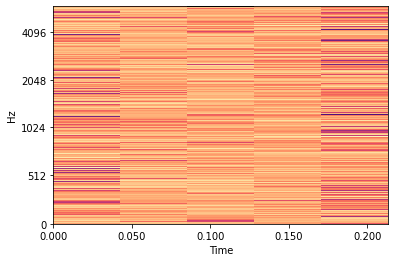

In [51]:
disc_acc = []
gen_loss = [0]
gan_acc = []
while p < 200:
    g_accuracy = 0
    d_accuracy = 0
    print("Step", e)
    e+=1
    if d_accuracy < 1:
        i, o = get_generator_outputs(wavelet_white_dataset, discriminator_train_size, gan.g, nperseg, wavelet_clean_dataset)
    gan.block_generator()
    err = get_distance_audio(wavelet_white_dataset, wavelet_clean_dataset, gan.g, 100)
    print("Training the discriminator")
    print("Generator error is", err)
    while d_accuracy < 0.9:
        d_accuracy = train_on_batch(gan.d, i, o, verbose=True)
        disc_acc.append(d_accuracy)
        gan_acc.append(0)
        gen_loss.append(err)
    gan.block_discriminator()
    print("Training the generator")
    while g_accuracy < 0.95:
        g_accuracy = train_on_batch(gan.combined_network, wavelet_white_dataset[:generator_train_size], np.ones(generator_train_size), batch_size=4, verbose=True)
        gan_acc.append(g_accuracy)
        disc_acc.append(0)
        err = get_distance_audio(wavelet_white_dataset, wavelet_clean_dataset, gan.g, 100)
        print(err)
        gen_loss.append(err)
        display_audio(wavelet_white_dataset, gan.g, p)
        p+=1
    #print(evaluate_generator(gan.g, white_dataset, clean_dataset))
plt.plot(disc_acc)
plt.plot(gan_acc)
plt.show()
plt.plot(gen_loss[1:])
plt.show()

#gan.combined_network.save('save4/gan_with_add')